In [1]:
pip install pykalman


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 3.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [25]:
df=pd.read_csv('drive/MyDrive/lab4/BIDV.csv')
df
df1=df.reset_index()['Close']

In [26]:
df

,Date,Open,High,Low,Close,Volume
0,2019-03-01 00:00:00+07:00,23001.22852,23354.00781,23001.22852,23177.61914,1634348
1,2019-03-04 00:00:00+07:00,23354.00781,23812.62109,23283.45313,23706.78906,1375277
2,2019-03-05 00:00:00+07:00,23424.56445,24906.23828,23424.56445,24412.34766,5974891
3,2019-03-06 00:00:00+07:00,24412.34766,24624.01563,24271.23633,24518.18164,2411789
4,2019-03-07 00:00:00+07:00,24694.57031,24870.96094,24482.90234,24624.01563,2413192
...,...,...,...,...,...,...
1301,2024-05-27 00:00:00+07:00,49400.00000,49400.00000,48550.00000,48900.00000,763312
1302,2024-05-28 00:00:00+07:00,49000.00000,49200.00000,48600.00000,49100.00000,1230902
1303,2024-05-29 00:00:00+07:00,49450.00000,49450.00000,48600.00000,48600.00000,1389049
1304,2024-05-30 00:00:00+07:00,48400.00000,48500.00000,47400.00000,47700.00000,2092022


In [27]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [28]:
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [29]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [30]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest= create_dataset(test_data, time_step)

In [31]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(ytest.shape)



(943, 100)
(943,)
(161, 100)
(161,)


In [32]:
kf = KalmanFilter(transition_matrices=[1],
                  observation_matrices=[1],
                  initial_state_mean=X_train[0][0],
                  initial_state_covariance=1,
                  observation_covariance=1,
                  transition_covariance=0.01)

In [33]:
kf = kf.em(X_train[0])

In [34]:
test_data.shape

(262, 1)

In [35]:
test_observed = test_data
test_predicted, _ = kf.filter(test_observed)


In [36]:
test_predicted.shape

(262, 1)

In [37]:
test_predicted=scaler.inverse_transform(test_predicted)
ytest=ytest.reshape(-1,1)
ytest=scaler.inverse_transform(test_data)

In [38]:
test_rmse = np.sqrt(np.mean((test_predicted - ytest)**2))
test_mae = mean_absolute_error(test_predicted, ytest)
test_mape = np.mean(np.abs(test_predicted - ytest)/np.abs(test_predicted))*100

In [39]:
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 808.8476063439821
Testing MAPE: 0.577264555993393
Testing MAE: 224.45391672277464


In [40]:
x_input=test_data[60:].reshape(1,-1)
x_input.shape[1]

202

In [41]:
test_data[60:].shape

(202, 1)

In [42]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
print(x_input.shape)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<90):

    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        #print(x_input)
        yhat, _ = kf.filter(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat[-1].tolist())
        i=i+1
    else:
        x_input = x_input.reshape(n_steps)
        yhat, _ = kf.filter(x_input)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat[-1].tolist())
        i=i+1

Streaming output truncated to the last 5000 lines.
 [0.21506118]
 [0.21184155]
 [0.21355513]
 [0.21407188]
 [0.21288546]
 [0.21279612]
 [0.20713175]
 [0.20247065]
 [0.20374955]
 [0.20145072]
 [0.20532112]
 [0.20138774]
 [0.19617485]
 [0.19487131]
 [0.19420976]
 [0.19401026]
 [0.1918025 ]
 [0.17825116]
 [0.17926516]
 [0.17473886]
 [0.17659531]
 [0.17581289]
 [0.17611384]
 [0.17593613]
 [0.1766879 ]
 [0.17879374]
 [0.17486514]
 [0.17180129]
 [0.16389765]
 [0.16258805]
 [0.16380381]
 [0.16309665]
 [0.16825239]
 [0.1668542 ]
 [0.16535877]
 [0.17269284]
 [0.1695355 ]
 [0.1642882 ]
 [0.16163201]
 [0.16968986]
 [0.17131442]
 [0.17341504]
 [0.17404849]
 [0.18014541]]
69 day input [0.48332245 0.48061771 0.50495953 0.53606296 0.52524436 0.50225491
 0.50901652 0.5306536  0.52118737 0.50495953 0.52253974 0.50495953
 0.52605752 0.5397729  0.52605752 0.54282076 0.55501221 0.55044041
 0.56110793 0.5793951  0.6190173  0.60377799 0.6190173  0.60987371
 0.60987371 0.60682585 0.59158654 0.59768227 0.6007

In [43]:
# Chuyển danh sách thành mảng numpy
values_array = np.array(lst_output)

# Nếu bạn thực sự cần reshape (ví dụ: thành mảng 2D 1 hàng)
values_reshaped = values_array.reshape(-1, 1)

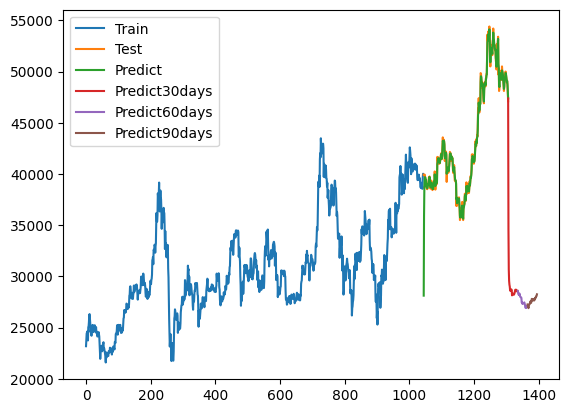

In [44]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,test_predicted)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(values_reshaped[0:30]))

prediect_data_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(values_reshaped[30:60]))

prediect_data_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(values_reshaped[60:90]))
plt.legend(['Train','Test','Predict','Predict30days', 'Predict60days', 'Predict90days'])
plt.show()



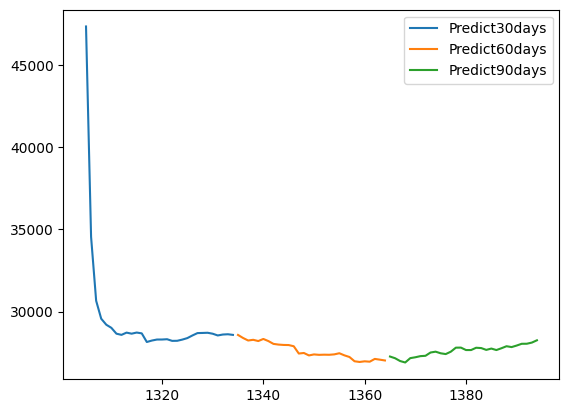

In [45]:


prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(values_reshaped[0:30]))

prediect_data_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(values_reshaped[30:60]))

prediect_data_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(values_reshaped[60:90]))

plt.legend(['Predict30days', 'Predict60days', 'Predict90days'])
plt.show()